# Take Home Assessment - Part 2 - Segmentation Model - Gauravi Patankar (gsp2137@columbia.edu)

### **Project Overview & Business Context**

- The dataset comprises population survey data containing rich information on individuals’ **demographic, educational, employment, and socioeconomic characteristics**.  
- The objective is to perform **unsupervised socio-demographic segmentation** and generate **target personas** that represent unique population groups.  
- Each segment will capture a coherent socio-demographic profile defined by attributes such as **age**, **education**, **occupation type**, **income proxies**, and **household structure**, among others.  

---

### **Assumption**

Since the details of the marketing campaign are **not specified**, this segmentation is treated as **exploratory** in nature, aimed at discovering **general**, meaningful, interpretable clusters rather than optimizing for a predefined campaign outcome.

---

### **Business Relevance**

> A segmentation model is only as valuable as the clarity of the business questions it answers.

While the dataset provides comprehensive socio-demographic information, the **absence of campaign-specific context** limits the ability to align clusters with direct marketing actions.  
To make the segmentation more targeted and actionable, the following **strategic questions** would ideally be clarified with the marketing or business team:

1. **Target Audience** – Which segment of the population is the campaign intended for? (e.g., working adults, families, students)  
2. **Granularity** – Do we need a few broad, easily interpretable personas, or more granular segments for precision targeting?  
3. **Ethical Boundaries** – Are there sensitive variables (e.g., race, nationality) that should be excluded from modeling for compliance or ethical reasons?  
4. **Actionability** – How will marketing leverage these clusters (for message tailoring, media planning, or outreach prioritization)?  

Addressing these questions would make the business objective explicit, helping focus the analysis on the most decision-relevant variables.

### Importing Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing, clustering, metrics, decomposition
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)

# Dimensionality reduction for visualization (optional)
from sklearn.manifold import TSNE

# Optional: for winsorization and outlier capping
from scipy.stats.mstats import winsorize

# Optional advanced visualization
import plotly.express as px

# General setup
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Random seed for reproducibility
np.random.seed(42)

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

### Data

In [3]:
# Reading column names
with open("census-bureau.columns") as f:
    columns = [line.strip() for line in f.readlines()]

# Reading data
df = pd.read_csv("census-bureau.data", names=columns, header=None)

In [4]:
# Viewing data
print(df.shape)
df.head()

(199523, 42)


,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,weight,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.090,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.550,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.950,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.140,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.160,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  int64  
 1   class of worker                             199523 non-null  object 
 2   detailed industry recode                    199523 non-null  int64  
 3   detailed occupation recode                  199523 non-null  int64  
 4   education                                   199523 non-null  object 
 5   wage per hour                               199523 non-null  int64  
 6   enroll in edu inst last wk                  199523 non-null  object 
 7   marital stat                                199523 non-null  object 
 8   major industry code                         199523 non-null  object 
 9   major occupation code                       199523 non-null  object 
 

### Data Cleaning

#### 1. Duplicates

In [6]:
df.duplicated().sum()

np.int64(3229)

In [7]:
df.drop_duplicates()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,weight,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.090,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.550,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.950,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.140,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.160,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,Not in universe,0,0,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Not in labor force,0,0,0,Joint both 65+,Not in universe,Not in universe,Householder,Householder,955.270,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Canada,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
199519,65,Self-employed-incorporated,37,2,11th grade,0,Not in u

#### 2. Fixing data types

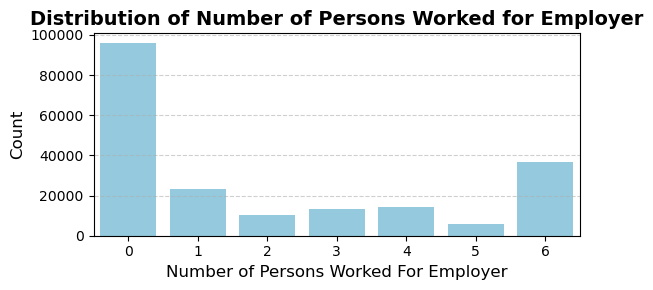

In [8]:
plt.figure(figsize=(6, 3))
sns.countplot(x='num persons worked for employer', data=df, color='skyblue')
plt.title('Distribution of Number of Persons Worked for Employer', fontsize=14, weight='bold')
plt.xlabel('Number of Persons Worked For Employer', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [9]:
df['num persons worked for employer'] = df['num persons worked for employer'].astype('category')

In [10]:
df['veterans benefits'].value_counts()

veterans benefits
2    150130
0     47409
1      1984
Name: count, dtype: int64

In [11]:
df["own business or self employed"].value_counts()

own business or self employed
0    180672
2     16153
1      2698
Name: count, dtype: int64

In [12]:
df['veterans benefits'] = df['veterans benefits'].astype('category')
df["own business or self employed"] = df['veterans benefits'].astype('category')

In [13]:
obj_cols = df.select_dtypes(include='object').columns
df[obj_cols] = df[obj_cols].apply(lambda col: col.astype('category'))

#### 3. Dropping Columns 

Dropping irrelevant columns for segmentation

In [14]:
# Drop detailed columns
drop_cols = [
    'detailed occupation recode',
    'detailed industry recode',
    'weight',
    'label',
    'year'
]
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)


#### 4. Simplify Categories

In [15]:
# education
df['education'] = df['education'].astype(str).str.strip().str.lower()
edu_group_map = {
    'less than 1st grade': 'Below High School',
    '1st 2nd 3rd or 4th grade': 'Below High School',
    '5th or 6th grade': 'Below High School',
    '7th and 8th grade': 'Below High School',
    '9th grade': 'Below High School',
    '10th grade': 'Below High School',
    '11th grade': 'Below High School',
    '12th grade no diploma': 'Below High School',
    'high school graduate': 'High School Graduate',
    'some college but no degree': 'Some College',
    'associates degree-occup /vocational': 'Associate Degree',
    'associates degree-academic program': 'Associate Degree',
    'bachelors degree(ba ab bs)': 'Bachelors Degree',
    'masters degree(ma ms meng med msw mba)': 'Graduate/Professional Degree',
    'prof school degree (md dds dvm llb jd)': 'Graduate/Professional Degree',
    'doctorate degree(phd edd)': 'Graduate/Professional Degree',
    'children': 'Children'
}
df['education'] = df['education'].map(edu_group_map)
df['education'] = df['education'].astype('category')

df['education'].value_counts(dropna=False)

education
High School Graduate            48407
Children                        47422
Below High School               36691
Some College                    27820
Bachelors Degree                19865
Associate Degree                 9721
Graduate/Professional Degree     9597
Name: count, dtype: int64

In [16]:
# detailed household and family stat

df['detailed household and family stat'] = (df['detailed household and family stat']
    .astype(str).str.strip().str.lower()
)
household_group_map = {
    # Householder
    'householder': 'Householder',
    'nonfamily householder': 'Householder',

    # Spouse/Partner
    'spouse of householder': 'Spouse/Partner',
    'spouse of rp of unrelated subfamily': 'Spouse/Partner',

    # Child
    'child <18 never marr not in subfamily': 'Child',
    'child 18+ never marr not in a subfamily': 'Child',
    'child 18+ ever marr not in a subfamily': 'Child',
    'child <18 ever marr not in subfamily': 'Child',
    'child 18+ spouse of subfamily rp': 'Child',
    'child <18 spouse of subfamily rp': 'Child',
    'child 18+ never marr rp of subfamily': 'Child',
    'child <18 never marr rp of subfamily': 'Child',
    'child 18+ ever marr rp of subfamily': 'Child',
    'child <18 ever marr rp of subfamily': 'Child',
    'child under 18 of rp of unrel subfamily': 'Child',

    # Grandchild
    'grandchild <18 never marr not in subfamily': 'Grandchild',
    'grandchild <18 ever marr not in subfamily': 'Grandchild',
    'grandchild 18+ never marr not in subfamily': 'Grandchild',
    'grandchild 18+ ever marr not in subfamily': 'Grandchild',
    'grandchild 18+ spouse of subfamily rp': 'Grandchild',
    'grandchild <18 never marr rp of subfamily': 'Grandchild',
    'grandchild <18 ever marr rp of subfamily': 'Grandchild',
    'grandchild 18+ ever marr rp of subfamily': 'Grandchild',
    'grandchild 18+ never marr rp of subfamily': 'Grandchild',
    'grandchild <18 never marr child of subfamily rp': 'Grandchild',

    # Other Relative
    'other rel 18+ ever marr not in subfamily': 'Other Relative',
    'other rel 18+ never marr not in subfamily': 'Other Relative',
    'other rel <18 never marr not in subfamily': 'Other Relative',
    'other rel <18 ever marr not in subfamily': 'Other Relative',
    'other rel 18+ spouse of subfamily rp': 'Other Relative',
    'other rel <18 spouse of subfamily rp': 'Other Relative',
    'other rel 18+ ever marr rp of subfamily': 'Other Relative',
    'other rel 18+ never marr rp of subfamily': 'Other Relative',
    'other rel <18 ever marr rp of subfamily': 'Other Relative',
    'other rel <18 never married rp of subfamily': 'Other Relative',
    'other rel <18 never marr child of subfamily rp': 'Other Relative',
    'other rel 18+ spouse of subfamily rp': 'Other Relative',
    'other rel 18+ ever marr rp of subfamily': 'Other Relative',

    # Non-relative/Secondary
    'secondary individual': 'Non-relative/Secondary',
    'rp of unrelated subfamily': 'Non-relative/Secondary',

    # Group quarters
    'in group quarters': 'Group Quarters'
}

df['detailed household and family stat'] = (
    df['detailed household and family stat']
    .map(household_group_map)
    .fillna('Other')
    .astype('category')
)

df['detailed household and family stat'].value_counts(dropna=False)

detailed household and family stat
Householder               75461
Child                     65614
Spouse/Partner            41747
Non-relative/Secondary     6807
Other Relative             6326
Grandchild                 3372
Group Quarters              196
Name: count, dtype: int64

In [17]:
# country
cols = ['country of birth father', 'country of birth mother', 'country of birth self']
region_map = {
    # --- North America ---
    'United-States': 'North America',
    'Canada': 'North America',

    # --- Latin America / Caribbean ---
    'Mexico': 'Latin America',
    'Puerto-Rico': 'Latin America',
    'Cuba': 'Latin America',
    'Dominican-Republic': 'Latin America',
    'Jamaica': 'Latin America',
    'Honduras': 'Latin America',
    'El-Salvador': 'Latin America',
    'Guatemala': 'Latin America',
    'Colombia': 'Latin America',
    'Ecuador': 'Latin America',
    'Peru': 'Latin America',
    'Nicaragua': 'Latin America',
    'Trinadad&Tobago': 'Latin America',
    'Haiti': 'Latin America',

    # --- Europe ---
    'England': 'Europe',
    'France': 'Europe',
    'Germany': 'Europe',
    'Italy': 'Europe',
    'Poland': 'Europe',
    'Portugal': 'Europe',
    'Ireland': 'Europe',
    'Scotland': 'Europe',
    'Greece': 'Europe',
    'Yugoslavia': 'Europe',
    'Hungary': 'Europe',
    'Holand-Netherlands': 'Europe',

    # --- Asia ---
    'China': 'Asia',
    'India': 'Asia',
    'Japan': 'Asia',
    'Philippines': 'Asia',
    'Vietnam': 'Asia',
    'Korea': 'Asia',
    'Cambodia': 'Asia',
    'Laos': 'Asia',
    'Thailand': 'Asia',
    'Taiwan': 'Asia',
    'Hong-Kong': 'Asia',

    # --- Middle East / Other ---
    'Iran': 'Middle East',
    'Israel': 'Middle East',
}

for col in cols:
    df[col] = df[col].map(region_map).fillna('Other')
    df[col] = df[col].astype('category')

for col in cols:
    print(f"\n{col} value counts:")
    print(df[col].value_counts())


country of birth father value counts:
country of birth father
North America    160543
Latin America     18680
Other              8147
Europe             7825
Asia               4095
Middle East         233
Name: count, dtype: int64

country of birth mother value counts:
country of birth mother
North America    161930
Latin America     18171
Other              7636
Europe             7417
Asia               4171
Middle East         198
Name: count, dtype: int64

country of birth self value counts:
country of birth self
North America    177689
Latin America     11229
Other              4545
Asia               2975
Europe             2928
Middle East         157
Name: count, dtype: int64


In [18]:
df['class of worker'] = df['class of worker'].replace({
    'Self-employed-not incorporated': 'Self-employed',
    'Self-employed-incorporated': 'Self-employed',
    'Local government': 'Government',
    'State government': 'Government',
    'Federal government': 'Government',
    'Without pay': 'Unemployed',
    'Never worked': 'Unemployed',
    'Not in universe': 'Not in labor force'
}).astype('category')

### Feature Engineering

In [19]:
# Create combined capital income proxy
if all(c in df.columns for c in ['capital gains', 'capital losses', 'dividends from stocks']):
    df['net_capital_income'] = (
        df['capital gains'].fillna(0) 
        - df['capital losses'].fillna(0) 
        + df['dividends from stocks'].fillna(0)
    )
    df.drop(['capital gains', 'capital losses', 'dividends from stocks'], axis=1, inplace=True)

# Create annual income proxy
if all(c in df.columns for c in ['wage per hour', 'weeks worked in year']):
    df['annual_income_proxy'] = (
        df['wage per hour'].fillna(0)
        * df['weeks worked in year'].fillna(0)
        * 40  # 40-hour week assumption
    )
    df.drop(['wage per hour', 'weeks worked in year'], axis=1, inplace=True)

In [20]:
# Domain defined age binning
bins = [0, 17, 25, 35, 50, 65, 100]
labels = ['Child (<18)', 'Young Adult (18–25)', 'Early Career (26–35)', 
          'Mid Career (36–50)', 'Late Career (51–65)', 'Senior (65+)']

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True, include_lowest=True)
df.drop(columns='age', inplace=True)

### Correlation Analysis using Cramer's V

In [21]:
cat_cols = [c for c in df.columns if df[c].dtype.name == 'category']

In [22]:
def cramers_v(x, y):
    """Compute Cramér’s V for two categorical pandas Series."""
    confusion = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    phi2 = chi2 / n
    r, k = confusion.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

In [23]:
cramers_results = pd.DataFrame(np.zeros((len(cat_cols), len(cat_cols))), 
                               index=cat_cols, columns=cat_cols)

for i, col1 in enumerate(cat_cols):
    for j, col2 in enumerate(cat_cols):
        if i < j:  # upper triangle only
            val = cramers_v(df[col1], df[col2])
            cramers_results.loc[col1, col2] = val
            cramers_results.loc[col2, col1] = val
np.fill_diagonal(cramers_results.values, np.nan)

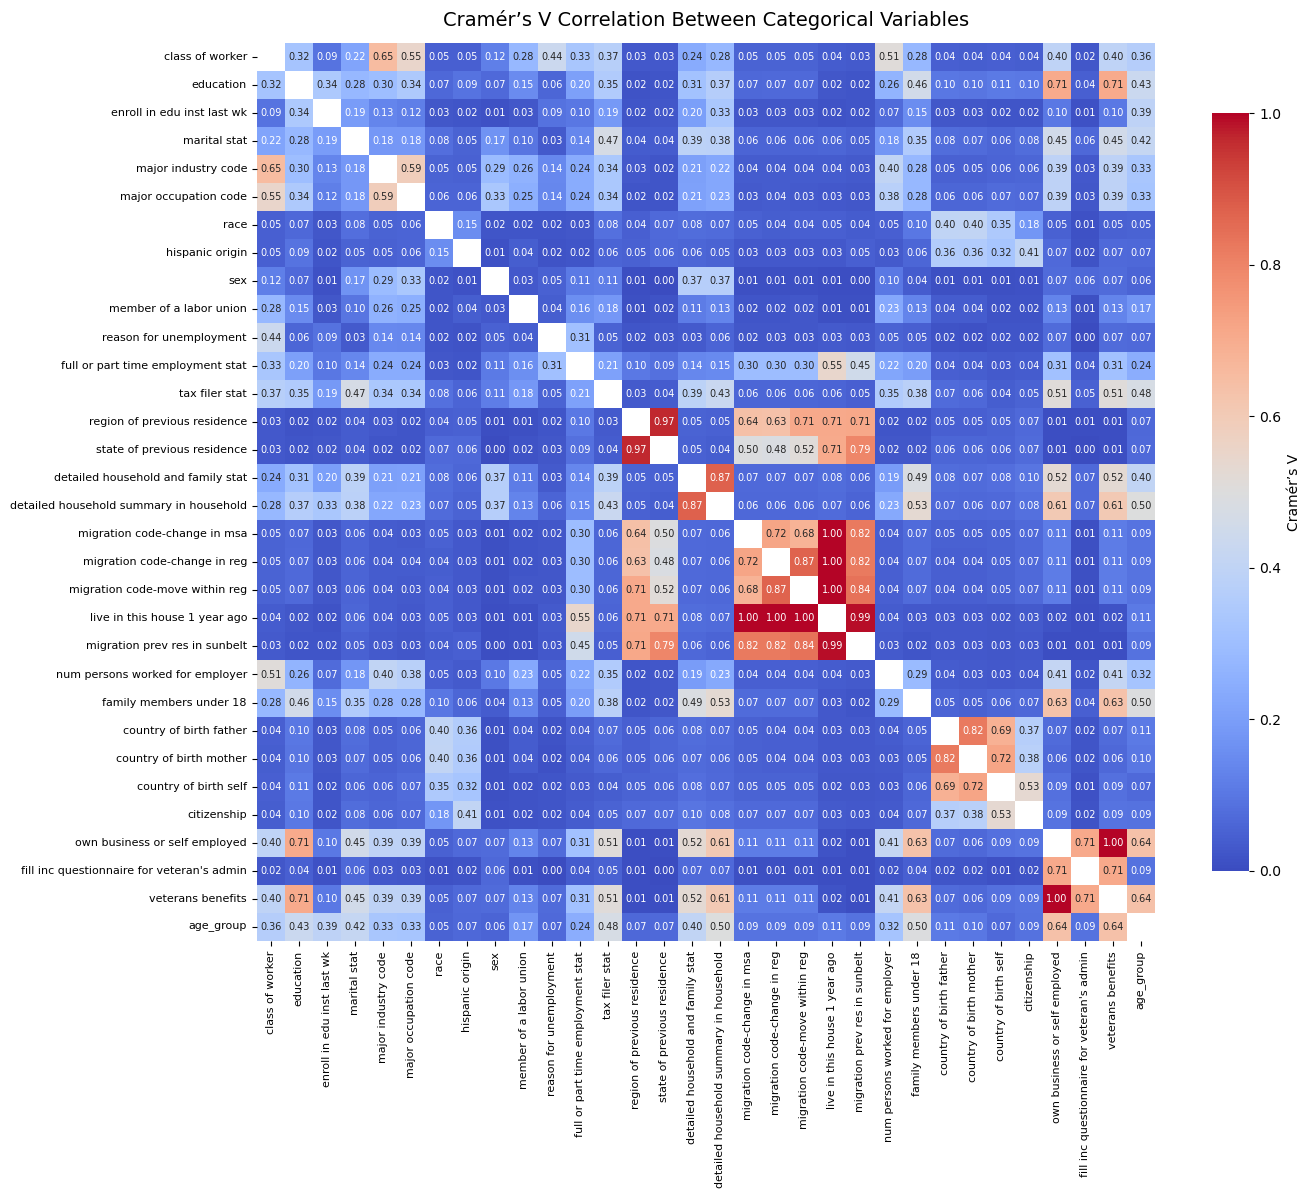

In [24]:
plt.figure(figsize=(14, 12))
sns.heatmap(
    cramers_results,
    cmap="coolwarm",
    vmin=0,
    vmax=1,
    square=True,
    annot=True,            # show correlation numbers
    fmt=".2f",             # 2 decimal places
    annot_kws={"size": 7}, # smaller font for readability
    cbar_kws={'shrink': 0.8, 'label': 'Cramér’s V'}
)
plt.title("Cramér’s V Correlation Between Categorical Variables", fontsize=14, pad=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()


In [25]:
threshold = 0.8  # adjust (e.g., 0.75–0.9)
high_corr_pairs = []
for c1 in cramers_results.columns:
    for c2 in cramers_results.index:
        if c1 != c2 and cramers_results.loc[c1, c2] >= threshold:
            high_corr_pairs.append((c1, c2, cramers_results.loc[c1, c2]))

high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Var1','Var2','CramersV'])

In [26]:
high_corr_df

,Var1,Var2,CramersV
0,region of previous residence,state of previous residence,0.966
1,state of previous residence,region of previous residence,0.966
2,detailed household and family stat,detailed household summary in household,0.871
3,detailed household summary in household,detailed household and family stat,0.871
4,migration code-change in msa,live in this house 1 year ago,1.000
5,migration code-change in msa,migration prev res in sunbelt,0.824
6,migration code-change in reg,migration code-move within reg,0.869
7,migration code-change in reg,live in this house 1 year ago,1.000
8,migration code-change in reg,migration prev res in sunbelt,0.822
9,migration code-move within reg,migration code-change in reg,0.869


In [27]:
drop_cols = [
    'migration code-change in msa',
    'migration code-change in reg',
    'migration code-move within reg',
    'migration prev res in sunbelt',
    'detailed household summary in household',
    'region of previous residence',
    'own business or self employed',
    "fill inc questionnaire for veteran's admin",
    'country of birth mother'
]

df = df.drop(columns=drop_cols)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 25 columns):
 #   Column                              Non-Null Count   Dtype   
---  ------                              --------------   -----   
 0   class of worker                     199523 non-null  category
 1   education                           199523 non-null  category
 2   enroll in edu inst last wk          199523 non-null  category
 3   marital stat                        199523 non-null  category
 4   major industry code                 199523 non-null  category
 5   major occupation code               199523 non-null  category
 6   race                                199523 non-null  category
 7   hispanic origin                     198649 non-null  category
 8   sex                                 199523 non-null  category
 9   member of a labor union             199523 non-null  category
 10  reason for unemployment             199523 non-null  category
 11  full or part 

### Encoding and Scaling

In [29]:
edu_order = [['Children',
              'Below High School',
              'High School Graduate',
              'Some College',
              'Associate Degree',
              'Bachelors Degree',
              'Graduate/Professional Degree']]

num_expected = ['annual_income_proxy', 'net_capital_income']
num_cols = [c for c in num_expected if c in df.columns]

use_edu = 'education' in df.columns

cat_cols = [c for c in df.select_dtypes(include=['category']).columns
            if c != 'education']  # exclude education

In [30]:
transformers = []
if num_cols:
    transformers.append(('num', RobustScaler(), num_cols))
if use_edu:
    transformers.append(('edu', OrdinalEncoder(categories=edu_order), ['education']))
if cat_cols:
    transformers.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols))

preprocessor = ColumnTransformer(transformers)

X = preprocessor.fit_transform(df)

In [31]:
def get_feature_names(ct: ColumnTransformer) -> list:
    names = []
    for name, transformer, cols in ct.transformers_:
        if hasattr(transformer, 'get_feature_names_out'):
            # e.g., OneHotEncoder
            fn = transformer.get_feature_names_out(cols).tolist()
            names.extend(fn)
        elif name == 'edu' and isinstance(cols, list) and len(cols) == 1:
            names.append(cols[0] + "_ord")
        else:
            # scalers (Robust/Standard) just keep original names
            names.extend(list(cols if isinstance(cols, (list, tuple, np.ndarray)) else [cols]))
    return names

feature_names = get_feature_names(preprocessor)
X_df = pd.DataFrame(X, columns=feature_names, index=df.index)

print(f"Encoded+scaled X shape: {X.shape}")
print(f" - numeric scaled: {len(num_cols)}")
print(f" - education ordinal: {int(use_edu)}")
print(f" - categorical OHE block: {X.shape[1] - len(num_cols) - int(use_edu)} features")


Encoded+scaled X shape: (199523, 196)
 - numeric scaled: 2
 - education ordinal: 1
 - categorical OHE block: 193 features


### K-selection

In [32]:
# Sampling data for faster K-selection

rng = np.random.default_rng(42)
n = X.shape[0]
sample_size = min(20000, n) 
X_sample = X[rng.choice(n, size=sample_size, replace=False)]
X_sample.shape

(20000, 196)

In [33]:
# Mini Batch KMeans
Ks = range(3, 11)
Ks = range(3, 11)
results = []

# Run multiple seeds per K to average metrics
for k in Ks:
    inertias, sils, chs = [], [], []
    for seed in [0, 1, 2]:
        km = MiniBatchKMeans(
            n_clusters=k,
            batch_size=4096,
            n_init=20,
            max_iter=300,
            random_state=seed
        ).fit(X_sample)
        labels = km.labels_
        inertias.append(km.inertia_)
        # silhouette on 3K subsample for speed
        idx = rng.choice(sample_size, size=min(3000, sample_size), replace=False)
        sils.append(silhouette_score(X_sample[idx], labels[idx]))
        chs.append(calinski_harabasz_score(X_sample, labels))
    results.append({
        "K": k,
        "Inertia_mean": np.mean(inertias),
        "Inertia_std": np.std(inertias),
        "Silhouette_mean": np.mean(sils),
        "CH_mean": np.mean(chs)
    })

results_df = pd.DataFrame(results)
display(results_df)

,K,Inertia_mean,Inertia_std,Silhouette_mean,CH_mean
0,3,1423961888243161.000,315431685492549.438,0.960,35654.934
1,4,1179134453601312.000,296258445085262.312,0.951,29488.214
2,5,1030453749839146.625,37073148578560.703,0.705,24366.879
3,6,1027777600448052.375,3692281960946.654,0.837,19566.200
4,7,971905977081710.500,86568632870658.297,0.866,17385.854
5,8,837049569234161.625,24950665244011.316,0.853,17343.324
6,9,910819833284662.875,70360232060282.031,0.323,13976.788
7,10,995231460840871.375,118132200912435.734,0.426,11800.866


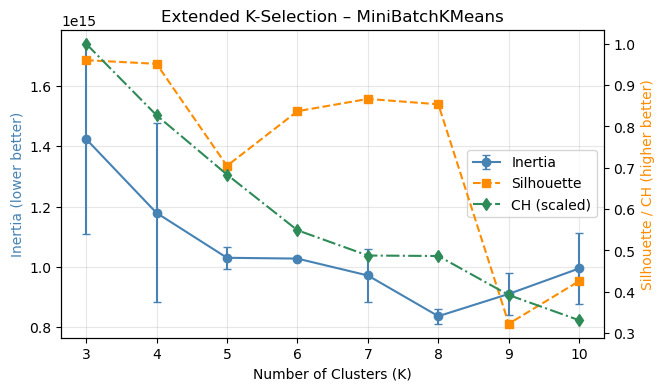

In [34]:
fig, ax1 = plt.subplots(figsize=(7,4))
ax2 = ax1.twinx()

ax1.errorbar(results_df["K"], results_df["Inertia_mean"],
             yerr=results_df["Inertia_std"], fmt='o-', color='steelblue', capsize=3, label='Inertia')
ax2.plot(results_df["K"], results_df["Silhouette_mean"], 's--', color='darkorange', label='Silhouette')
ax2.plot(results_df["K"], results_df["CH_mean"]/results_df["CH_mean"].max(), 'd-.', color='seagreen', label='CH (scaled)')

ax1.set_xlabel("Number of Clusters (K)")
ax1.set_ylabel("Inertia (lower better)", color='steelblue')
ax2.set_ylabel("Silhouette / CH (higher better)", color='darkorange')
ax1.set_title("Extended K-Selection – MiniBatchKMeans")
ax1.grid(alpha=0.3)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='center right')

plt.show()

In [35]:
from kneed import KneeLocator

kneedle = KneeLocator(
    results_df["K"],
    results_df["Inertia_mean"],
    curve="convex",
    direction="decreasing"
)
auto_k = kneedle.knee
print(f" K = {auto_k}")

 K = 5


- The elbow in Inertia happens around K = 5 — confirmed by the Kneedle algorithm.
- Silhouette and CH both remain strong up to K ≈ 6–7 but fall sharply beyond that.
- From 3 → 4 → 5, the Silhouette drops because the model starts separating previously cohesive groups. After K = 6, improvements spike and then drop.

#### ***Best estimate: K = 5 or 6***

**Logic for not considering K=8:**
1. The biggest drop in Inertia happens between K=3 → K=5, and after that, the curve flattens out. That's a strong indicator that adding clusters beyond 5 gives diminishing returns.
2. Prioritized the CH score over the Silhouette score while choosing since CH tends to remain more stable and robust to local variations, whereas Silhouette can fluctuate due to smaller or uneven clusters.

### Mini Batch K Means

In [36]:
final_kmeans = MiniBatchKMeans(
    n_clusters=5,
    batch_size=4096,
    n_init=30,
    random_state=42
)
df['cluster'] = final_kmeans.fit_predict(X)
df['cluster'] = df['cluster'].astype('category')

### Building Cluster Profiles/ Personas

In [37]:
# Cluster Sizes
cluster_summary = df['cluster'].value_counts().sort_index()
print("Cluster Sizes:")
print(cluster_summary, "\n")
print(f"Total samples: {len(df)}")
print(f"Cluster Proportions (%):\n{(cluster_summary / len(df) * 100).round(2)}")

Cluster Sizes:
cluster
0      1412
1      2680
2    183927
3      6926
4      4578
Name: count, dtype: int64 

Total samples: 199523
Cluster Proportions (%):
cluster
0    0.710
1    1.340
2   92.180
3    3.470
4    2.290
Name: count, dtype: float64


In [38]:
# Numeric Summaries
num_cols = ['annual_income_proxy', 'net_capital_income']
if all(col in df.columns for col in num_cols):
    num_summary = (
        df.groupby('cluster')[num_cols]
          .agg(['mean', 'median', 'std'])
          .round(2)
    )
    display(num_summary)

annual_income_proxy                         net_capital_income  \
                       mean      median         std               mean   
cluster                                                                  
0                411066.010  418000.000  194929.430            105.940   
1               3620695.690 3236480.000 1642130.630            785.280   
2                     0.180       0.000      44.360             94.990   
3               1508523.140 1456000.000  443901.770            235.310   
4                     0.000       0.000       0.000          21264.260   

                             
           median       std  
cluster                      
0           0.000  1126.550  
1           0.000  4766.730  
2           0.000   674.120  
3           0.000  2351.720  
4       10898.000 27659.970

- Cluster 0: Moderate-income population, likely working-class or lower-middle-income earners with limited investment exposure.
- Cluster 1: Very high earners → average incomes in the millions, moderate capital income. Likely wealthy professionals or high-executive households.
- Cluster 2: Essentially zero income, both wages and capital income are negligible, likely non-working population (children, students, retirees, or not in labor force).
- Cluster 3: Mid-to-upper-income earners with modest capital income, steady full-time workers, professionals, etc. 
- Cluster 4: No labor income, but significant investment or capital income → Likely retirees or high-wealth individuals living off investments.

In [39]:
cat_cols = [c for c in df.select_dtypes(include='category').columns if c != 'cluster']

def top_categories(series, top_n=3):
    freq = series.value_counts(normalize=True).head(top_n)
    return ', '.join([f"{idx} ({p*100:.1f}%)" for idx, p in freq.items()])

cat_summary = pd.DataFrame({
    col: df.groupby('cluster')[col].apply(top_categories)
    for col in cat_cols
})
display(cat_summary.T) 

cluster,0,1,2,3,4
class of worker,"Private (89.9%), Government (10.1%), Unemploye...","Private (78.0%), Government (22.0%), Unemploye...","Not in labor force (53.9%), Private (32.9%), G...","Private (87.9%), Government (12.1%), Unemploye...","Private (45.9%), Not in labor force (25.2%), S..."
education,"Below High School (34.3%), High School Graduat...","High School Graduate (36.9%), Some College (20...","Children (25.8%), High School Graduate (23.5%)...","High School Graduate (42.4%), Some College (24...","Bachelors Degree (31.0%), Graduate/Professiona..."
enroll in edu inst last wk,"Not in universe (68.5%), High school (18.6%), ...","Not in universe (99.6%), College or university...","Not in universe (93.7%), High school (3.5%), C...","Not in universe (91.5%), College or university...","Not in universe (99.3%), College or university..."
marital stat,"Never married (57.9%), Married-civilian spouse...","Married-civilian spouse present (69.6%), Never...","Never married (45.0%), Married-civilian spouse...","Married-civilian spouse present (51.9%), Never...","Married-civilian spouse present (73.3%), Never..."
major industry code,"Retail trade (40.0%), Education (8.6%), Busine...","Manufacturing-durable goods (15.7%), Hospital ...","Not in universe or children (54.1%), Retail tr...","Retail trade (23.1%), Manufacturing-durable go...","Not in universe or children (25.2%), Manufactu..."
major occupation code,"Other service (32.2%), Sales (15.4%), Adm supp...","Precision production craft & repair (23.7%), P...","Not in universe (54.1%), Adm support including...","Adm support including clerical (21.5%), Other ...","Not in universe (25.2%), Executive admin and m..."
race,"White (85.7%), Black (10.1%), Amer Indian Aleu...","White (87.5%), Black (8.2%), Asian or Pacific ...","White (83.6%), Black (10.4%), Asian or Pacific...","White (83.4%), Black (11.8%), Asian or Pacific...","White (92.2%), Black (3.5%), Asian or Pacific ..."
hispanic origin,"All other (90.6%), Mexican-American (3.0%), Me...","All other (94.0%), Mexican-American (2.2%), Me...","All other (86.0%), Mexican-American (4.2%), Me...","All other (91.1%), Mexican (Mexicano) (3.2%), ...","All other (95.7%), Mexican-American (1.3%), Ot..."
sex,"Female (59.6%), Male (40.4%)","Male (64.9%), Female (35.1%)","Female (52.7%), Male (47.3%)","Female (56.4%), Male (43.6%)","Male (69.9%), Female (30.1%)"
member of a labor union,"No (95.6%), Yes (4.4%), Not in universe (0.0%)","No (63.5%), Yes (36.5%), Not in universe (0.0%)","Not in universe (95.9%), No (3.5%), Yes (0.5%)","No (86.8%), Yes (13.2%), Not in universe (0.0%)","Not in universe (88.8%), No (9.7%), Yes (1.4%)"


**Cluster 0:** young adults (18–25), female-majority, employed in private sector (90%), mainly in retail trade or service occupations.

**Cluster 1:** Mostly men (65%), mid-career (36–50), employed in private/government sectors with manufacturing and hospital services dominance

**Cluster 2:** Large share of children (< 18), not in labor force (54%), mostly female, and never married.

**Cluster 3:** Mixed gender, early- to mid-career adults (26–50), mostly private employees in clerical / administrative / service roles.

**Cluster 4:** Predominantly men (70%), late-career to senior (50+), private or self-employed, many householders, few dependents.

## Based on the above numeric and categorical composition analysis, these are the customer segments:

#### 1. Cluster 0 — Young Working-Class Employees
#### 2. Cluster 1 — Mid-Career Married Professionals
#### 3. Cluster 2 — Non-Earning / Dependent Population
#### 4. Cluster 3 — Mid-Income Dual-Worker Households
#### 5. Cluster 4 — Educated, High-Wealth / Retired Investors

In [41]:
persona_data = [
    {
        "Cluster": "0 – Young Working-Class Employees",
        "Economic Tier": "Lower income",
        "Employment Type": "Private wage earners",
        "Profile Summary": (
            "Young adults (18–25), mainly female, employed in retail/service sectors. "
            "Low education (Below HS/HS Grad), never married, low income (~400K), minimal assets."
        )
    },
    {
        "Cluster": "1 – Married Skilled Professionals",
        "Economic Tier": "Upper-middle income",
        "Employment Type": "Private / Government professionals",
        "Profile Summary": (
            "Mid-career men (36–50), married, high wages (~3.6M), modest capital income. "
            "Educated, steady jobs in manufacturing and hospital sectors."
        )
    },
    {
        "Cluster": "2 – Dependents / Non-workers",
        "Economic Tier": "Low / inactive",
        "Employment Type": "Not in labor force",
        "Profile Summary": (
            "Children, students, or unemployed adults; minimal or zero income and assets. "
            "Largely dependents supported by others in household."
        )
    },
    {
        "Cluster": "3 – Steady Working Households",
        "Economic Tier": "Middle income",
        "Employment Type": "Private / Clerical / Service roles",
        "Profile Summary": (
            "Early-to-mid-career adults (26–50), mix of genders, high-school educated, "
            "stable full-time employment (~1.5M income), modest investments."
        )
    },
    {
        "Cluster": "4 – Educated Asset-Rich Retirees",
        "Economic Tier": "High wealth",
        "Employment Type": "Self-employed / Retired investors",
        "Profile Summary": (
            "Older men (50+), highly educated (Bachelor’s+), married, "
            "no wage income but high capital income (~21K). Financially independent households."
        )
    }
]

# Convert to DataFrame
persona_df = pd.DataFrame(persona_data)

# === Styling for Notebook Display ===
def color_tier(val):
    if "Low" in val: return "background-color:#ffe6e6"
    if "Middle" in val: return "background-color:#fff5cc"
    if "Upper" in val: return "background-color:#e6f3ff"
    if "High" in val: return "background-color:#d6f5d6"
    return ""

styled = (
    persona_df.style
        .set_properties(**{
            'text-align': 'left', 
            'white-space': 'pre-wrap',
            'font-size': '13px'
        })
        .applymap(color_tier, subset=["Economic Tier"])
        .hide(axis='index')
        .set_table_styles([
            {"selector": "th", "props": [("font-size", "13px"), ("text-align", "left"), ("background-color", "#f0f0f0")]},
            {"selector": "td", "props": [("border", "1px solid #ddd"), ("padding", "8px")]}
        ])
)
display(styled)

Cluster,Economic Tier,Employment Type,Profile Summary
0 – Young Working-Class Employees,Lower income,Private wage earners,"Young adults (18–25), mainly female, employed in retail/service sectors. Low education (Below HS/HS Grad), never married, low income (~400K), minimal assets."
1 – Married Skilled Professionals,Upper-middle income,Private / Government professionals,"Mid-career men (36–50), married, high wages (~3.6M), modest capital income. Educated, steady jobs in manufacturing and hospital sectors."
2 – Dependents / Non-workers,Low / inactive,Not in labor force,"Children, students, or unemployed adults; minimal or zero income and assets. Largely dependents supported by others in household."
3 – Steady Working Households,Middle income,Private / Clerical / Service roles,"Early-to-mid-career adults (26–50), mix of genders, high-school educated, stable full-time employment (~1.5M income), modest investments."
4 – Educated Asset-Rich Retirees,High wealth,Self-employed / Retired investors,"Older men (50+), highly educated (Bachelor’s+), married, no wage income but high capital income (~21K). Financially independent households."


### Future Scope

1. Although *MiniBatch K-Means* produced clear and interpretable clusters, exploring other clustering algorithms like DBSCAN, Hierarchical Clustering, etc. could help uncover more complex or non-linear group structures.

2. Incorporating PCA (Principal Component Analysis) before clustering can reduce redundancy among correlated features, enhance cluster stability, and allow for clear 2D/3D visualizations of group separation.

3. Future work can also include statistical validation (ANOVA, Chi-Square) and predictive modeling, training a classifier to automatically assign new individuals to socio-demographic segments based on their characteristics.